This is a simple feed forward network that uses opening times, and volume data to predict microsoft stock closing price.

Data scaler used is standardization
Activation function used is ReLU
loss function used is MSE = Mean squared Error loss
Optimization used is Adam

This network consists of 4 layers: input, hidden layer 1 (32 neurons), hidden layer 2 (32), and output layer with 1 class.
The database we have is from kaggle

FINAL EVALUATION METRIC:
- What we use is R squares: 0.85-0.95
- Down below you can see the plot with the testing data

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')


In [5]:
# Opening up the dataset from path
data = pd.read_csv("../../datasets/Microsoft_Stock.csv")

# Choosing the features (independent variables) and labels (dependent variables) 
features = data.loc[:,["Volume", "Open"]]
labels = data.loc[:,"Close"]

#Scale the features and labels
scaler = StandardScaler()
features = scaler.fit_transform(np.asarray(features))
labels = scaler.fit_transform(np.asarray(labels).reshape(-1,1))

# Turn them into tensors
features = torch.tensor(features, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32).to(device)

# Split them into training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, train_size=0.8)
data

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [3]:
# Hyperparams
epochs = 5
batchsize = 10
lr = 0.0001
inputsz = features.shape[1]
h1sz = 32
h2sz = 32
outsz = labels.shape[1]
activation = nn.ReLU()

In [4]:
# Creating a custom dataset class
class MSFTData(Dataset):
    def __init__(self, features: torch.tensor, labels: torch.tensor, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self,idx):
        input = self.features[idx]
        label = self.labels[idx]
        if self.transform!=None:
            input = self.transform(input)
        return input, label

In [5]:
# Creating model architechture
class FFmodel(nn.Module):
    def __init__(self, input_sz, hid1_sz, hid2_sz, output_sz, activation=nn.ReLU()):
        super(FFmodel, self).__init__()
        self.sequence = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_sz, hid1_sz),
            activation,
            nn.Linear(hid1_sz, hid2_sz),
            activation,
            nn.Linear(hid2_sz, output_sz)            
        )
    def forward(self, x):
        out = self.sequence(x)
        return out

In [6]:
# Initializing the model, and the data
model = FFmodel(input_sz=inputsz, hid1_sz=h1sz, hid2_sz=h2sz, output_sz=outsz, activation=activation).to(device)

traindb = MSFTData(xtrain,ytrain)
testdb = MSFTData(xtest,ytest)

trainloader = torch.utils.data.DataLoader(traindb, batch_size=batchsize, shuffle=False, drop_last=False)
testloader = torch.utils.data.DataLoader(testdb, batch_size=batchsize, shuffle=False, drop_last=False)

# Choosing and creating lossfunction and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [7]:
trainloader.dataset.features.shape, trainloader.dataset.labels.shape

(torch.Size([1208, 2]), torch.Size([1208, 1]))

In [8]:
# Training the model with the training dataloader
model.train()
for epoch in range(epochs):
    for i, (inputs, label) in enumerate(trainloader):
        inputs = inputs.to(device)
        label = label.to(device)

        output = model(inputs)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [9]:
from torchmetrics.regression import R2Score
model.eval()

# Initializing the metric for evaluating the overall performance of the model.
r2_metric = R2Score().to(device)

#Saving the predicted values and the actual values
predicted = []
actuals = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        predicted.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())
        # Update R2 metric with predictions and true labels
        r2_metric.update(outputs, labels)
        
# Compute the R2 score for the entire test dataset
r2_score = r2_metric.compute()
print(f"R2 Score on the test set: {r2_score:.4f}")

# Optionally, reset the metric if you plan to use it again
r2_metric.reset()

R2 Score on the test set: 0.9497


In [10]:
# Checking a single batch test predictions and comparing them with the actual.
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        out = scaler.inverse_transform(out.cpu().numpy())
        labels = scaler.inverse_transform(labels.cpu().numpy())
        print(f"predicted:\n {out}\n\n label: \n{labels}")
        break

predicted:
 [[109.65973 ]
 [100.343735]
 [100.00888 ]
 [ 71.041145]
 [104.676765]
 [ 70.44027 ]
 [ 95.33046 ]
 [ 67.84291 ]
 [ 63.154083]
 [146.45927 ]]

 label: 
[[107.66]
 [ 99.08]
 [ 98.31]
 [ 61.97]
 [105.25]
 [ 63.52]
 [ 85.01]
 [ 48.72]
 [ 46.75]
 [138.12]]


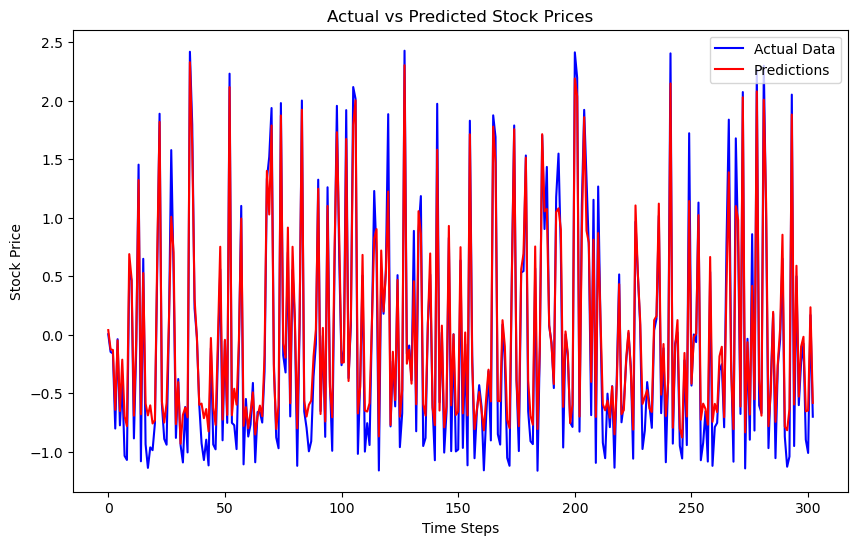

In [21]:
#PLOTTING THE MODEL
# Convert to numpy arrays for easier plotting
actual_values = np.array(actuals)
predicted_values = np.array(predicted)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Data', color='blue')
plt.plot(predicted_values, label='Predictions', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()
